# Testing Propensity and Exposure Values

The purpose of this notebook was to check why exposure means were seen to be decreasing over the course of the sim. It was suspected the propensities might be drifting over time. Basically that we were killing all of the high risk simulants and so the high propensity values were leaving the sim. This was designed to test that theory

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from vivarium import InteractiveContext, Artifact

from datetime import datetime, timedelta
from pathlib import Path
import itertools
import matplotlib.pyplot as plt
import ipywidgets
import pandas as pd, numpy as np
pd.set_option('display.max_rows', 60)

import numpy as np
import researchpy as rp
import statsmodels.api as sm
import statsmodels.formula.api as smf
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns

from db_queries import get_outputs as go
from db_queries import get_ids
from get_draws.api import get_draws

## Load in Data and First Time Step

In [2]:
path = Path('/ihme/homes/lutzes/vivarium_nih_us_cvd/src/vivarium_nih_us_cvd/model_specifications/nih_us_cvd.yaml')
sim = InteractiveContext(path, setup=False)

sim.configuration.update({
                          'population':
                              {'population_size': 50_000,
                              },
                          'time':
                              {'start':
                                  {'year': 2021
                                  }
                              }
                          }
                        )
sim.setup()

2023-08-15 10:16:50.865 | INFO     | simulation_1-artifact_manager:66 - Running simulation from artifact located at /mnt/team/simulation_science/costeffectiveness/artifacts/vivarium_nih_us_cvd/alabama.hdf.
2023-08-15 10:16:50.867 | INFO     | simulation_1-artifact_manager:67 - Artifact base filter terms are ['draw == 0'].
2023-08-15 10:16:50.868 | INFO     | simulation_1-artifact_manager:68 - Artifact additional filter terms are None.


In [3]:
pop0 = sim.get_population()
pop0.head()

,tracked,sex,alive,entrance_time,location,exit_time,age,years_of_life_lost,cause_of_death,years_lived_with_disability,...,ldlc_multiplier,sbp_medication,ldlc_medication_adherence,lifestyle_adherence,ldlc_medication,lifestyle,sbp_therapeutic_inertia_propensity,visit_type,last_fpg_test_date,scheduled_date
0,True,Female,alive,2020-12-04,Alabama,NaT,47.388882,0.0,not_dead,0.0,...,1.0,one_drug_half_dose_efficacy,cat3,True,no_treatment,NaT,0.022599,none,NaT,NaT
1,True,Male,alive,2020-12-04,Alabama,NaT,41.564194,0.0,not_dead,0.0,...,1.0,no_treatment,cat3,False,no_treatment,NaT,0.742067,none,NaT,NaT
2,True,Female,alive,2020-12-04,Alabama,NaT,53.155826,0.0,not_dead,0.0,...,1.0,no_treatment,cat3,False,no_treatment,NaT,0.591302,none,NaT,NaT
3,True,Male,alive,2020-12-04,Alabama,NaT,30.457692,0.0,not_dead,0.0,...,1.0,no_treatment,cat1,True,no_treatment,NaT,0.273953,none,NaT,NaT
4,True,Female,alive,2020-12-04,Alabama,NaT,19.554806,0.0,not_dead,0.0,...,1.0,no_treatment,cat3,False,no_treatment,NaT,0.455919,none,NaT,NaT


In [4]:
#pop0.columns

In [5]:
#sim.list_values()

In [6]:
data1 = pd.concat([pop0,
                   sim.get_value('high_ldl_cholesterol.exposure')(pop0.index).rename('high_ldl'),
                   sim.get_value('high_systolic_blood_pressure.exposure')(pop0.index).rename('high_sbp'),
                   sim.get_value('high_body_mass_index_in_adults.exposure')(pop0.index).rename('high_bmi'),
                   sim.get_value('high_fasting_plasma_glucose.exposure')(pop0.index).rename('high_fpg'),
                   sim.get_value('high_ldl_cholesterol.propensity')(pop0.index).rename('high_ldl_prop'),
                   sim.get_value('high_systolic_blood_pressure.propensity')(pop0.index).rename('high_sbp_prop'),
                   sim.get_value('high_body_mass_index_in_adults.propensity')(pop0.index).rename('high_bmi_prop'),
                   sim.get_value('high_fasting_plasma_glucose.propensity')(pop0.index).rename('high_fpg_prop'),
                   sim.get_value('heart_failure_from_ischemic_heart_disease.incidence_rate')(pop0.index).rename('hf_ihd'),
                   sim.get_value('heart_failure_residual.incidence_rate')(pop0.index).rename('hf_resid'),
                   sim.get_value('acute_myocardial_infarction.incidence_rate')(pop0.index).rename('acute_mi'),
                   sim.get_value('acute_ischemic_stroke.incidence_rate')(pop0.index).rename('stroke'),
                   sim.get_value('post_myocardial_infarction_to_acute_myocardial_infarction.transition_rate')(pop0.index).rename('post_stroke'),
                  ], axis=1)
data1.head()

,tracked,sex,alive,entrance_time,location,exit_time,age,years_of_life_lost,cause_of_death,years_lived_with_disability,...,high_fpg,high_ldl_prop,high_sbp_prop,high_bmi_prop,high_fpg_prop,hf_ihd,hf_resid,acute_mi,stroke,post_stroke
0,True,Female,alive,2020-12-04,Alabama,NaT,47.388882,0.0,not_dead,0.0,...,7.655254,0.173110,0.843299,0.135403,0.930157,0.000027,0.000072,0.000036,0.000011,0.000036
1,True,Male,alive,2020-12-04,Alabama,NaT,41.564194,0.0,not_dead,0.0,...,9.447039,0.187950,0.788239,0.159066,0.950051,0.000018,0.000051,0.000117,0.000009,0.000117
2,True,Female,alive,2020-12-04,Alabama,NaT,53.155826,0.0,not_dead,0.0,...,8.609653,0.168561,0.861751,0.120914,0.920093,0.000058,0.000106,0.000055,0.000035,0.000055
3,True,Male,alive,2020-12-04,Alabama,NaT,30.457692,0.0,not_dead,0.0,...,8.511144,0.192373,0.769485,0.165581,0.954638,0.000014,0.000062,0.000040,0.000004,0.000040
4,True,Female,alive,2020-12-04,Alabama,NaT,19.554806,0.0,not_dead,0.0,...,1.000000,0.179608,0.820149,0.147086,0.939978,0.000001,0.000024,0.000008,0.000006,0.000008


In [7]:
data1 = data1.loc[(data1.age > 25) & (data1.alive == 'alive')]
data1['age_start'] = ((data1.age/5).astype(int) * 5).astype(float)

In [8]:
data1.head()

,tracked,sex,alive,entrance_time,location,exit_time,age,years_of_life_lost,cause_of_death,years_lived_with_disability,...,high_ldl_prop,high_sbp_prop,high_bmi_prop,high_fpg_prop,hf_ihd,hf_resid,acute_mi,stroke,post_stroke,age_start
0,True,Female,alive,2020-12-04,Alabama,NaT,47.388882,0.0,not_dead,0.0,...,0.173110,0.843299,0.135403,0.930157,0.000027,0.000072,0.000036,0.000011,0.000036,45.0
1,True,Male,alive,2020-12-04,Alabama,NaT,41.564194,0.0,not_dead,0.0,...,0.187950,0.788239,0.159066,0.950051,0.000018,0.000051,0.000117,0.000009,0.000117,40.0
2,True,Female,alive,2020-12-04,Alabama,NaT,53.155826,0.0,not_dead,0.0,...,0.168561,0.861751,0.120914,0.920093,0.000058,0.000106,0.000055,0.000035,0.000055,50.0
3,True,Male,alive,2020-12-04,Alabama,NaT,30.457692,0.0,not_dead,0.0,...,0.192373,0.769485,0.165581,0.954638,0.000014,0.000062,0.000040,0.000004,0.000040,30.0
6,True,Male,alive,2020-12-04,Alabama,NaT,28.652525,0.0,not_dead,0.0,...,0.706285,0.911835,0.884554,0.633719,0.000013,0.000086,0.000076,0.000004,0.000076,25.0


In [9]:
## Limiting to a smaller group, selected randomly 

data1_small = data1.loc[(data1.sex=='Male') & (data1.age_start == 85) | (data1.age_start == 65)]
data1_small

,tracked,sex,alive,entrance_time,location,exit_time,age,years_of_life_lost,cause_of_death,years_lived_with_disability,...,high_ldl_prop,high_sbp_prop,high_bmi_prop,high_fpg_prop,hf_ihd,hf_resid,acute_mi,stroke,post_stroke,age_start
9,True,Male,alive,2020-12-04,Alabama,NaT,68.924497,0.0,not_dead,0.0,...,0.178486,0.886667,0.091491,0.901807,0.000771,0.000659,0.000862,0.000222,0.000862,65.0
17,True,Male,alive,2020-12-04,Alabama,NaT,85.850152,0.0,not_dead,0.0,...,0.376975,0.925326,0.053183,0.849460,0.005931,0.004898,0.000681,0.000406,0.000681,85.0
19,True,Female,alive,2020-12-04,Alabama,NaT,69.243338,0.0,not_dead,0.0,...,0.371144,0.016150,0.844051,0.528043,0.000477,0.000567,0.000140,0.000069,0.000140,65.0
44,True,Male,alive,2020-12-04,Alabama,NaT,88.305092,0.0,not_dead,0.0,...,0.712410,0.859283,0.892909,0.713266,0.007833,0.006469,0.001076,0.000519,0.001076,85.0
72,True,Male,alive,2020-12-04,Alabama,NaT,68.573683,0.0,not_dead,0.0,...,0.725710,0.879777,0.880395,0.695558,0.001089,0.000932,0.002418,0.000414,0.002418,65.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49920,True,Female,alive,2020-12-04,Alabama,NaT,68.827284,0.0,not_dead,0.0,...,0.029092,0.764213,0.639812,0.777344,0.000677,0.000805,0.000278,0.000171,0.000278,65.0
49941,True,Female,alive,2020-12-04,Alabama,NaT,68.287674,0.0,not_dead,0.0,...,0.509505,0.651223,0.092192,0.482711,0.000511,0.000607,0.000138,0.000071,0.000138,65.0
49948,True,Male,alive,2020-12-04,Alabama,NaT,85.419356,0.0,not_dead,0.0,...,0.953696,0.317376,0.630211,0.165595,0.005108,0.004219,0.000442,0.000296,0.000442,85.0
49973,True,Female,alive,2020-12-04,Alabama,NaT,67.597729,0.0,not_dead,0.0,...,0.444335,0.515561,0.110723,0.691779,0.000461,0.000548,0.000127,0.000070,0.000127,65.0


In [10]:
risks = list(['high_sbp_prop','high_bmi_prop','high_fpg_prop','high_ldl_prop'])

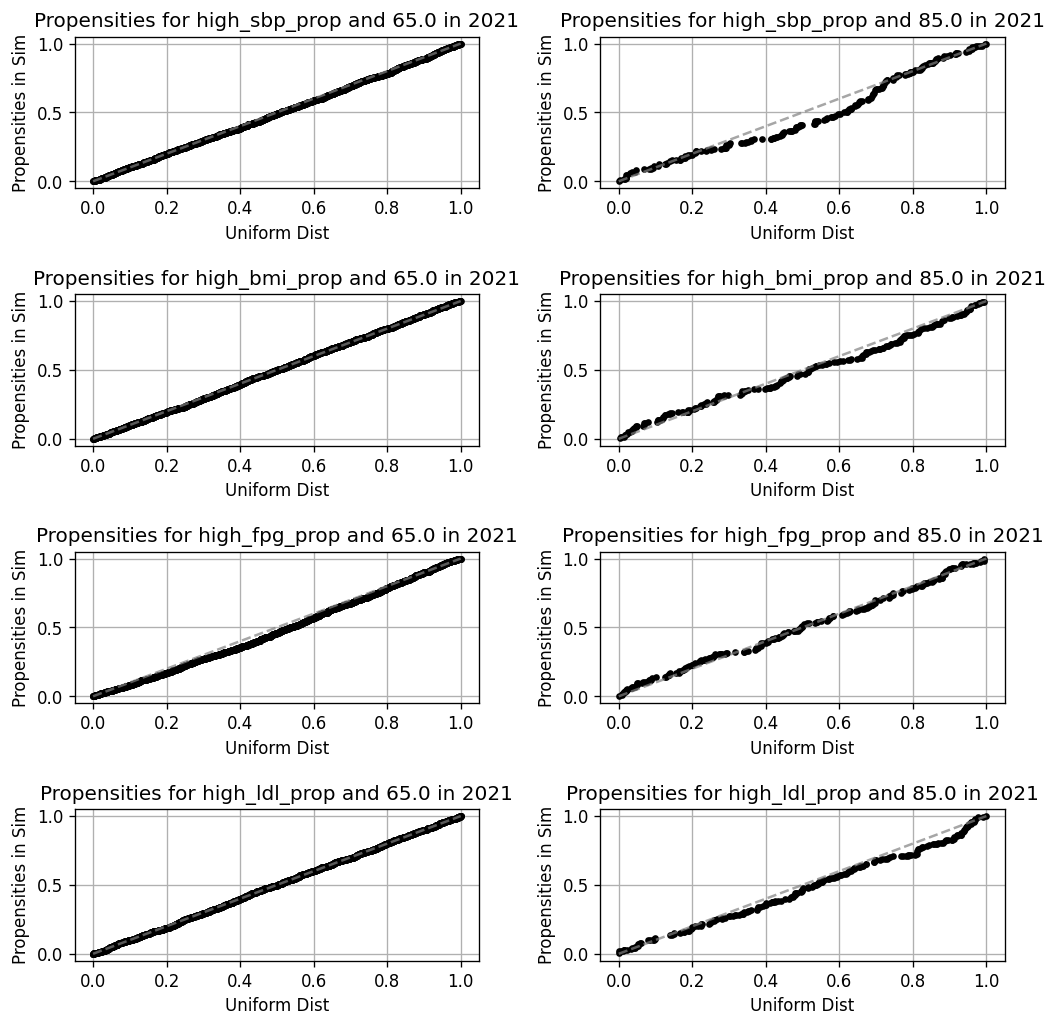

In [11]:
fig, ax = plt.subplots(len(risks), data1_small.age_start.nunique(), dpi=120, figsize=(10,10))
plt.subplots_adjust(wspace=.3, hspace=.7)
for i, risk in enumerate(risks):
    for j, age in enumerate(data1_small.age_start.unique()):
        d = data1_small.query('age_start == @age')
        
        ax[i][j].plot(np.sort(np.random.uniform(size=len(d))),
         d[risk].sort_values(), 'k.')
        ax[i][j].plot([0,1], [0,1], '--', color='grey', alpha=.7)
        ax[i][j].grid()
        ax[i][j].set_xlabel('Uniform Dist')
        ax[i][j].set_ylabel('Propensities in Sim');
        ax[i][j].set_title(f'Propensities for {risk} and {age} in 2021')
        

In [12]:
## These propensities look good! This is expected, at the first time step we think they will be correct. 

## Now we run the sim forward 3 years to see how this drifts over time

In [13]:
%%time

sim_data = pd.DataFrame()
for step in list(range(0,12*3)):
    print(step, end=', ', flush=True)
    sim.step()
    pop_t = sim.get_population()
    data_t = pd.concat([pop_t, 
                   sim.get_value('high_ldl_cholesterol.exposure')(pop0.index).rename('high_ldl'),
                   sim.get_value('high_systolic_blood_pressure.exposure')(pop0.index).rename('high_sbp'),
                   sim.get_value('high_body_mass_index_in_adults.exposure')(pop0.index).rename('high_bmi'),
                   sim.get_value('high_fasting_plasma_glucose.exposure')(pop0.index).rename('high_fpg'),
                   sim.get_value('high_ldl_cholesterol.propensity')(pop0.index).rename('high_ldl_prop'),
                   sim.get_value('high_systolic_blood_pressure.propensity')(pop0.index).rename('high_sbp_prop'),
                   sim.get_value('high_body_mass_index_in_adults.propensity')(pop0.index).rename('high_bmi_prop'),
                   sim.get_value('high_fasting_plasma_glucose.propensity')(pop0.index).rename('high_fpg_prop')],
                       axis=1)
    data_t['step'] = step
    sim_data = pd.concat([sim_data, data_t])

0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, CPU times: user 3h 15min 31s, sys: 43 s, total: 3h 16min 14s
Wall time: 3h 16min 11s


In [14]:
test_data = sim_data
test_data = test_data.loc[(test_data.age > 25) & (test_data.alive == 'alive')]
test_data['age_start'] = ((test_data.age/5).astype(int) * 5).astype(float)
test_data_small = test_data.loc[(test_data.step==35) & (test_data.sex=='Male')]
test_data_small = test_data_small.loc[(test_data_small.age_start == 85) | (test_data_small.age_start == 65)]
test_data_small

,tracked,sex,alive,entrance_time,location,exit_time,age,years_of_life_lost,cause_of_death,years_lived_with_disability,...,high_ldl,high_sbp,high_bmi,high_fpg,high_ldl_prop,high_sbp_prop,high_bmi_prop,high_fpg_prop,step,age_start
17,True,Male,alive,2020-12-04,Alabama,NaT,88.609906,0.0,not_dead,0.0,...,1.775686,165.682147,18.672833,7.070729,0.376975,0.925326,0.053183,0.849460,35,85.0
55,True,Male,alive,2020-12-04,Alabama,NaT,65.571499,0.0,not_dead,0.0,...,4.488889,154.737172,31.048298,6.486256,0.914731,0.902511,0.624729,0.589374,35,65.0
79,True,Male,alive,2020-12-04,Alabama,NaT,69.068138,0.0,not_dead,0.0,...,2.827366,133.673138,27.117842,7.258124,0.489231,0.835388,0.357192,0.762067,35,65.0
159,True,Male,alive,2020-12-04,Alabama,NaT,66.375045,0.0,not_dead,0.0,...,2.132772,134.075226,34.284987,8.164361,0.161270,0.853139,0.800253,0.821717,35,65.0
197,True,Male,alive,2020-12-04,Alabama,NaT,65.159680,0.0,not_dead,0.0,...,3.275797,114.273751,26.632285,6.432274,0.629529,0.069672,0.320516,0.634795,35,65.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49892,True,Male,alive,2020-12-04,Alabama,NaT,66.928011,0.0,not_dead,0.0,...,2.961094,108.031225,22.524737,8.087339,0.401598,0.049409,0.064240,0.842461,35,65.0
49894,True,Male,alive,2020-12-04,Alabama,NaT,69.953455,0.0,not_dead,0.0,...,2.570641,101.010006,41.209701,5.414258,0.331305,0.006753,0.960054,0.388126,35,65.0
49910,True,Male,alive,2020-12-04,Alabama,NaT,68.740062,0.0,not_dead,0.0,...,2.730199,122.627515,28.699692,3.996373,0.417379,0.222213,0.479800,0.031805,35,65.0
49948,True,Male,alive,2020-12-04,Alabama,NaT,88.179109,0.0,not_dead,0.0,...,4.342147,127.007478,28.491167,4.684822,0.953696,0.317376,0.630211,0.165595,35,85.0


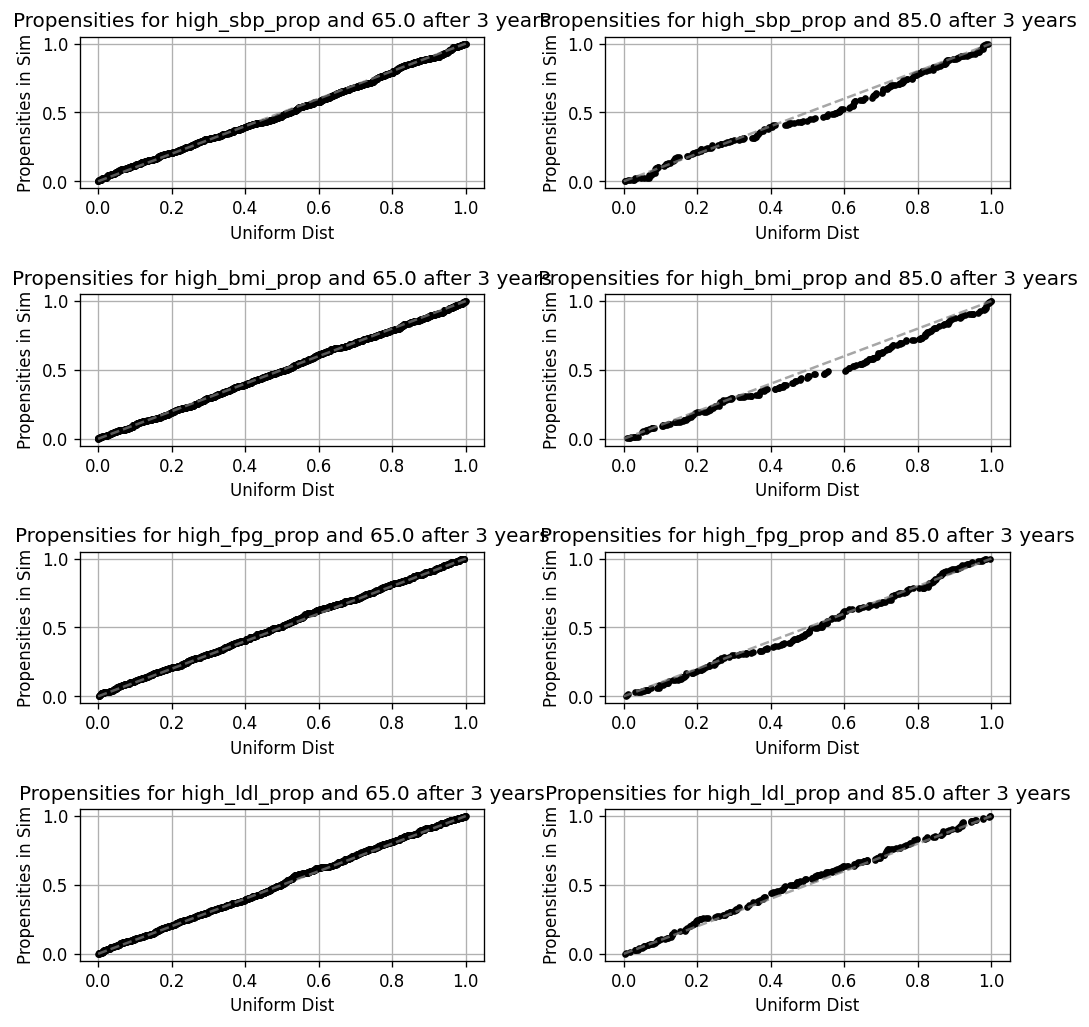

In [15]:
fig, ax = plt.subplots(len(risks), data1_small.age_start.nunique(), dpi=120, figsize=(10,10))
plt.subplots_adjust(wspace=.3, hspace=.7)
for i, risk in enumerate(risks):
    for j, age in enumerate(data1_small.age_start.unique()):
        d = test_data_small.query('age_start == @age')
        
        ax[i][j].plot(np.sort(np.random.uniform(size=len(d))),
         d[risk].sort_values(), 'k.')
        ax[i][j].plot([0,1], [0,1], '--', color='grey', alpha=.7)
        ax[i][j].grid()
        ax[i][j].set_xlabel('Uniform Dist')
        ax[i][j].set_ylabel('Propensities in Sim');
        ax[i][j].set_title(f'Propensities for {risk} and {age} after 3 years')
        

We don't see a lot of drift in the above plots! These look pretty good overall. We are now looking at the SBP exposure values to see if that provides any additional information 


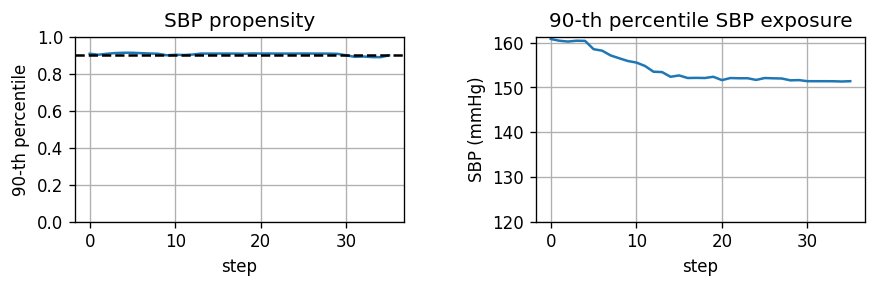

In [16]:
## Looking at the 90th percentile value for SBP exposure - we would also expect this to remain stable over time. 

q = 90
age = 80
sex = "Male"
t = sim_data.query('alive == "alive" and sex == @sex and age >= @age and age < @age+5')

plt.figure(figsize=(8.5,2), dpi=120)
plt.subplot(1,2,1)
t.groupby('step').high_sbp_prop.apply(np.percentile, q=q).plot()
plt.axhline(q/100, color='k', linestyle='--')
plt.axis(ymin=0, ymax=1)
plt.ylabel(f'{q}-th percentile')
plt.title('SBP propensity')
plt.grid()

plt.subplot(1,2,2)
t.groupby('step').high_sbp.apply(np.percentile, q=q).plot()
# plt.axhline(120, color='k', linestyle='--')
plt.axis(ymin=120)
plt.ylabel(f'SBP (mmHg)')
plt.title(f'{q}-th percentile SBP exposure')
plt.grid()

plt.subplots_adjust(wspace=.4);

In [17]:
# It decreases! But the propensity doesn't decrease, which is odd. 

## This was never solved and is still an issue in the model. This is still an interesting example in debugging. 